In [1]:
import os
import sys
import pandas as pd
import yaml 
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from matplotlib import colors as mcolors
from matplotlib import patches as mpatches
import statsmodels.api as sm
import numpy as np
from itertools import product
import subprocess
import networkx as nx

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 11

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor, XGBClassifier

import shap

with open("../../config.yaml.local", "r") as f:
    LOCAL_CONFIG = yaml.safe_load(f)
with open("../../config.yaml", "r") as f:
    CONFIG = yaml.safe_load(f)
sys.path.append("../python")

import globals
import data_tools as dt
import writing_tools as wt
import utils
import emb

LOCAL_PATH = LOCAL_CONFIG["LOCAL_PATH"]
RAW_DATA_PATH = LOCAL_CONFIG["RAW_DATA_PATH"]
DATA_PATH = LOCAL_CONFIG["DATA_PATH"]
R_PATH = LOCAL_CONFIG["R_PATH"]

RUN_R_SCRIPTS = False
OVERWRITE = False


/Users/ekung/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ekung/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
# Some basic data cleaning / wranging

df = dt.get_v4v_analysis_data(overwrite=OVERWRITE)

print(len(df))

/Users/ekung/projects/sn-research/src/notebooks/../python/data_tools.py:89: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.dt.to_period('W-SAT').dt.start_time


191334


In [3]:
# Table showing some determinants of post quality

tbl = "\\renewcommand{\\arraystretch}{1.2} \n"
tbl += "\\begin{tabular}{lcccc} \n"
tbl += "\\toprule \n"
tbl += "  & \\multicolumn{1}{c}{Has images or links}  &   \\multicolumn{3}{c}{Number of words} \\\\ \n"
tbl += "  & \\multicolumn{1}{c}{in post body?}        &   None       & 1-50       & >50        \\\\ \\hline  \n"
for link_post in [True, False]:
    if link_post:
        tbl += "\\multirow{6}{*}{Is link post} & "
    else:
        tbl += "\\multirow{6}{*}{Not link post} & "
    for img_or_link in [False, True]:
        if img_or_link:
            tbl += " & \\multirow{3}{*}{Yes} "
        else:
            tbl += "\\multirow{3}{*}{No} "
        for word_cat in ['no_words', 'lo_words', 'hi_words']:
            if (word_cat == 'no_words') & (img_or_link == True):
                tbl += " & "
                continue
            mask = (df['is_link_post'] == link_post) & (df['has_img_or_links'] == img_or_link) & (df[word_cat])
            zaps48 = df.loc[mask, 'sats48'].mean()
            tbl += f"& $\\bar{{z}} = {zaps48:,.0f}$"
        tbl += " \\\\ \n"
        tbl += " & "
        for word_cat in ['no_words', 'lo_words', 'hi_words']:
            if (word_cat == 'no_words') & (img_or_link == True):
                tbl += " & "
                continue
            mask = (df['is_link_post'] == link_post) & (df['has_img_or_links'] == img_or_link) & (df[word_cat])
            comments48 = df.loc[mask, 'comments48'].mean()
            tbl += f"& $\\bar{{c}} = {comments48:,.1f}$"
        tbl += " \\\\ \n"
        tbl += " & "
        for word_cat in ['no_words', 'lo_words', 'hi_words']:
            if (word_cat == 'no_words') & (img_or_link == True):
                tbl += " & "
                continue
            mask = (df['is_link_post'] == link_post) & (df['has_img_or_links'] == img_or_link) & (df[word_cat])
            n_posts = len(df.loc[mask])
            tbl += f"& $N = {n_posts:,.0f}$"
        if img_or_link == False:
            tbl += " \\\\ \\cline{2-5} \n "
        else:
            tbl += " \\\\ \\hline \n"
tbl += "\\end{tabular} \n"
tbl += "\\renewcommand{\\arraystretch}{1} \n"
print(tbl)

with open(os.path.join(LOCAL_PATH, "results", "tbl_quality_determinants.tex"), "w") as f:
    f.write(tbl)


\renewcommand{\arraystretch}{1.2} 
\begin{tabular}{lcccc} 
\toprule 
  & \multicolumn{1}{c}{Has images or links}  &   \multicolumn{3}{c}{Number of words} \\ 
  & \multicolumn{1}{c}{in post body?}        &   None       & 1-50       & >50        \\ \hline  
\multirow{6}{*}{Is link post} & \multirow{3}{*}{No} & $\bar{z} = 166$& $\bar{z} = 214$& $\bar{z} = 250$ \\ 
 & & $\bar{c} = 1.2$& $\bar{c} = 2.4$& $\bar{c} = 2.7$ \\ 
 & & $N = 91,721$& $N = 10,392$& $N = 10,486$ \\ \cline{2-5} 
  & \multirow{3}{*}{Yes}  & & $\bar{z} = 202$& $\bar{z} = 513$ \\ 
 &  & & $\bar{c} = 1.3$& $\bar{c} = 3.5$ \\ 
 &  & & $N = 6,308$& $N = 5,899$ \\ \hline 
\multirow{6}{*}{Not link post} & \multirow{3}{*}{No} & $\bar{z} = 309$& $\bar{z} = 371$& $\bar{z} = 706$ \\ 
 & & $\bar{c} = 7.0$& $\bar{c} = 8.6$& $\bar{c} = 10.1$ \\ 
 & & $N = 1,725$& $N = 8,917$& $N = 15,251$ \\ \cline{2-5} 
  & \multirow{3}{*}{Yes}  & & $\bar{z} = 280$& $\bar{z} = 1,303$ \\ 
 &  & & $\bar{c} = 3.7$& $\bar{c} = 8.0$ \\ 
 &  & & $N = 17,

In [4]:
# High quality posts

wt.update_results({
    "NumberHighQuality": f"{df['hi_quality'].sum():,.0f}",
    "NumberLowQuality": f"{(~df['hi_quality']).sum():,.0f}",
    "ShareHighQuality": f"{df['hi_quality'].mean()*100:.1f}"
})



{'PostsCostElasticity': '-0.265',
 'PostsCostDoublingEffect': '16.8',
 'Zaps48CostElasticity': '0.219',
 'Zaps48CostDoublingEffect': '16.4',
 'Comments48CostElasticity': '0.043',
 'Comments48CostDoublingEffect': '3.0',
 'NumItems': '1,121,485',
 'NumPosts': '207,219',
 'NumComments': '914,266',
 'NumUsers': '11,228',
 'NumTerritories': '117',
 'StartDate': 'June 11, 2021',
 'EndDate': 'October 5, 2025',
 'TotalZaps': '146 million',
 'NonCustodialDate': 'January 3, 2025',
 'TotalCost': '13 million',
 'Sats48': '94',
 'Comments48': '90',
 'NumPostingFeeChanges': '199',
 'AvgPostingCost': '51',
 'AvgSats48': '364',
 'AvgComments48': '3.3',
 'SdPostingCost': '241',
 'SdSats48': '6,662',
 'SdComments48': '9.6',
 'AvgPostingCostCents': '5',
 'NumberHighQuality': '44,682',
 'NumberLowQuality': '146,652',
 'HighQualityEffect': '7.1',
 'ShareHighQuality': '23.4',
 'InactiveRateBaseline': '14.1',
 'UnprofitableExitEffect': '5.5',
 'UnprofitableExitBTCGrowthEffect': '6.1'}

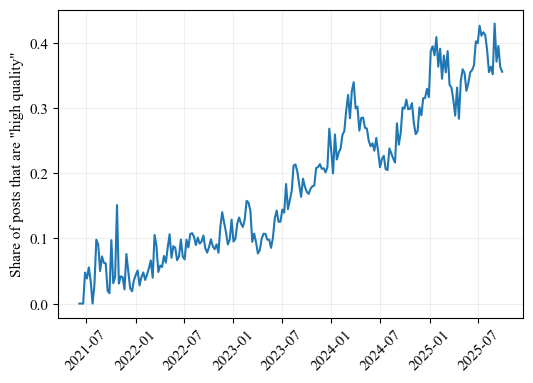

In [5]:
# Plot quality over time

plot_df = df.groupby('week').agg(
    total_posts = ('itemId', 'count'),
    hi_quality_posts = ('hi_quality', 'sum')
).reset_index()

plt.figure(figsize = (6,4))
plt.plot(plot_df['week'], plot_df['hi_quality_posts'] / plot_df['total_posts'])
plt.xticks(rotation=45)
plt.grid(alpha=0.2)
plt.ylabel('Share of posts that are "high quality"')
plt.savefig(os.path.join(LOCAL_PATH, "results", "fig_quality_over_time.pdf"), bbox_inches='tight')
plt.show()


In [6]:
res = subprocess.run([R_PATH, LOCAL_PATH + "/src/R/v4v-analysis.R"], check=True, capture_output=True, text=True)
print(res.stdout)


% Table created by stargazer v.5.2.3 by Marek Hlavac, Social Policy Institute. E-mail: marek.hlavac at gmail.com
% Date and time: Mon, Dec 22, 2025 - 09:35:58
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lcccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & \multicolumn{4}{c}{\textit{Dependent variable:}} \\ 
\cline{2-5} 
\\[-1.8ex] & \multicolumn{4}{c}{hi\_quality} \\ 
\\[-1.8ex] & (1) & (2) & (3) & (4)\\ 
\hline \\[-1.8ex] 
 High quality share of prior zaps & 0.670$^{***}$ & 0.690$^{***}$ & 0.114$^{***}$ & 0.128$^{***}$ \\ 
  & (0.002) & (0.002) & (0.005) & (0.005) \\ 
  & & & & \\ 
 log(Prior zaps) &  & $-$0.013$^{***}$ & $-$0.008$^{***}$ & $-$0.014$^{***}$ \\ 
  &  & (0.0003) & (0.001) & (0.001) \\ 
  & & & & \\ 
 High quality share of prior posts &  &  & 0.844$^{***}$ & 0.807$^{***}$ \\ 
  &  &  & (0.006) & (0.006) \\ 
  & & & & \\ 
 log(Prior posts) &  &  & $-$0.003$^{***}$ & $-$0.001 \\ 
  &  &  & (0.001) & (0.001) \\ 
  & & & & \\ 
 

In [7]:
coefs = pd.read_csv(
    os.path.join(DATA_PATH, 'v4v_learning_coefs.csv'),
    index_col = 0
)

coef = coefs.loc['hi_quality_share', 'coef(r4)']

wt.update_results({
    'HighQualityEffect': f"{(coef*0.5)*100:.1f}"
})

{'PostsCostElasticity': '-0.265',
 'PostsCostDoublingEffect': '16.8',
 'Zaps48CostElasticity': '0.219',
 'Zaps48CostDoublingEffect': '16.4',
 'Comments48CostElasticity': '0.043',
 'Comments48CostDoublingEffect': '3.0',
 'NumItems': '1,121,485',
 'NumPosts': '207,219',
 'NumComments': '914,266',
 'NumUsers': '11,228',
 'NumTerritories': '117',
 'StartDate': 'June 11, 2021',
 'EndDate': 'October 5, 2025',
 'TotalZaps': '146 million',
 'NonCustodialDate': 'January 3, 2025',
 'TotalCost': '13 million',
 'Sats48': '94',
 'Comments48': '90',
 'NumPostingFeeChanges': '199',
 'AvgPostingCost': '51',
 'AvgSats48': '364',
 'AvgComments48': '3.3',
 'SdPostingCost': '241',
 'SdSats48': '6,662',
 'SdComments48': '9.6',
 'AvgPostingCostCents': '5',
 'NumberHighQuality': '44,682',
 'NumberLowQuality': '146,652',
 'HighQualityEffect': '6.4',
 'ShareHighQuality': '23.4',
 'InactiveRateBaseline': '14.1',
 'UnprofitableExitEffect': '5.5',
 'UnprofitableExitBTCGrowthEffect': '6.1'}